In [64]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment ? - Llama3.2 3b on chat mode

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: Gemma3 12b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [65]:
os.listdir()


['resp_analysis6_deepseek.ipynb',
 'resp_analysis5.ipynb',
 'week_0317_zs_cot_chat_prompting_llama3b.ipynb',
 'week_0317_zs_cot_chat_prompting_gemma3_12b.ipynb',
 'resp_analysis4_ZS.ipynb',
 'resp_analysis6_phi3.ipynb',
 'week_0310_llama8b_as_judgeon_extracted_answers.ipynb',
 'week_0224_llama8b_as_judge.ipynb',
 'blame.txt',
 'resp_analysis6_deepseek7b.ipynb',
 'week_0224_correlation_llama3bvs8b.ipynb',
 'resp_analysis6_llama8b.ipynb',
 'resp_analysis6_llama3b.ipynb',
 'resp_analysis.ipynb',
 'week_0303_llama8b_as_judge_improving_correlation.ipynb',
 'resp_analysis3.ipynb',
 'week_0234_oneshot_nohtml_tags.ipynb',
 'resp_analysis4_OS.ipynb',
 'resp_analysis2.ipynb',
 'week_0224_llama3b_bias_check.ipynb',
 'week_0303_resp_analysis6_llama8b_regex_extract_last.ipynb',
 'hallucinations_investigation.ipynb']

In [66]:
with open('../data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [67]:
with open('../data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [68]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [69]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [70]:
predictions = []
with open('../outputs/responses_gemma3:12b_20250321_15:20:00_chat.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [71]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [72]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])

In [73]:
predictions_df['answer'].iloc[0:5] 

id
Interaction_T1_13           ```json\n{"answer": "B. The blanket"}\n```
Interaction_T1_14          ```json\n{"answer": "A. The blanket."}\n```
Interaction_T1_31          ```json\n{"answer": "C. The clothes."}\n```
Interaction_T1_32             ```json\n{"answer": "B. The shoe."}\n```
Interaction_T1_40    ```json\n{"answer": "B. The closet/cabinet"}\n```
Name: answer, dtype: object

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [74]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7091
Percentage following JSON template: 99.90%


In [75]:
predictions_df.loc[~json_mask, 'answer']

id
Interaction_T1_9288    The STSG describes a person holding a bag and ...
Interaction_T2_2180    Here's a step-by-step reasoning and the final ...
Sequence_T2_5648                                                        
Sequence_T3_5556       The question asks what happened *after* the pe...
Sequence_T6_1137       Here's the reasoning and the final answer in J...
Sequence_T6_1408       Here's the reasoning and the final answer in J...
Feasibility_T4_81      Here's the reasoning and the final answer in J...
Name: answer, dtype: object

In [78]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']

id
Interaction_T1_13             {"answer": "B. The blanket"}
Interaction_T1_14            {"answer": "A. The blanket."}
Interaction_T1_31            {"answer": "C. The clothes."}
Interaction_T1_32               {"answer": "B. The shoe."}
Interaction_T1_40      {"answer": "B. The closet/cabinet"}
                                      ...                 
Feasibility_T6_1453       {"answer": "A. Wash the table."}
Feasibility_T6_1454       {"answer": "A. Take the towel."}
Feasibility_T6_1455       {"answer": "B. Wash the table."}
Feasibility_T6_1456       {"answer": "D. Wash the table."}
Feasibility_T6_1468        {"answer": "B. Hold the food."}
Name: answer, Length: 7098, dtype: object

In [81]:
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )

In [82]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df

,chat_history,answer
id,,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully...",B. The blanket
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",A. The blanket.
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes.
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",B. The shoe.
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",B. The closet/cabinet
...,...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully...",A. Wash the table.
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully...",A. Take the towel.
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully...",B. Wash the table.


In [84]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")

Answer following the template: 6758
95.21% of the total

Only 340 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_35087/4018721229.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [85]:
predictions_df.loc[~contains_answer, 'answer']

id
Interaction_T1_287     None of the alternatives are correct based on ...
Interaction_T1_460     None of the provided alternatives are mentione...
Interaction_T1_1671    The STSG does not provide information about an...
Interaction_T1_4142    The STSG does not provide information about an...
Interaction_T1_4382    None of the provided alternatives are mentione...
                                             ...                        
Prediction_T1_856      None of the alternatives are suitable. The per...
Feasibility_T4_81      Here's the reasoning and the final answer in J...
Feasibility_T5_562     The question is flawed as the STSG does not pr...
Feasibility_T6_54                                       Unable to answer
Feasibility_T6_155        The answer is not present in the alternatives.
Name: answer, Length: 340, dtype: object

## Extract answers

In [87]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The blanket.
Interaction_T1_14,The blanket.
Interaction_T1_31,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The closet/cabinet.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Take the towel.
Feasibility_T6_1455,Wash the table.


In [88]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6758 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6758 non-null   object
dtypes: object(1)
memory usage: 105.6+ KB


In [89]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 444 unique answers


In [90]:
ans_df['text'].value_counts()


Took.                         636
Put down.                     347
The book.                     192
The towel.                    190
The clothes.                  185
                             ... 
the picture.                    1
Hold the closet/cabinet.        1
Hold the refrigerator.          1
Open the sandwich.              1
Take the cup/glass/bottle.      1
Name: text, Length: 222, dtype: int64

<AxesSubplot: xlabel='freq', ylabel='word'>

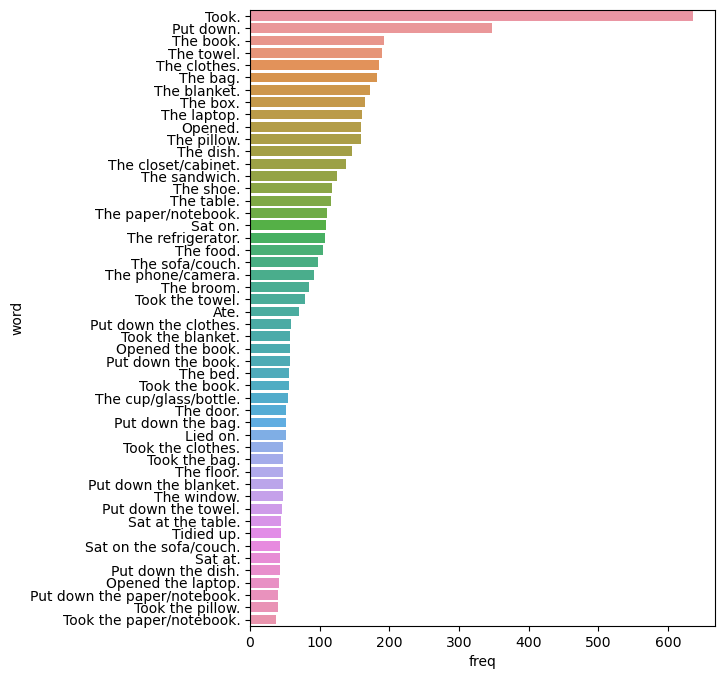

In [91]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [92]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

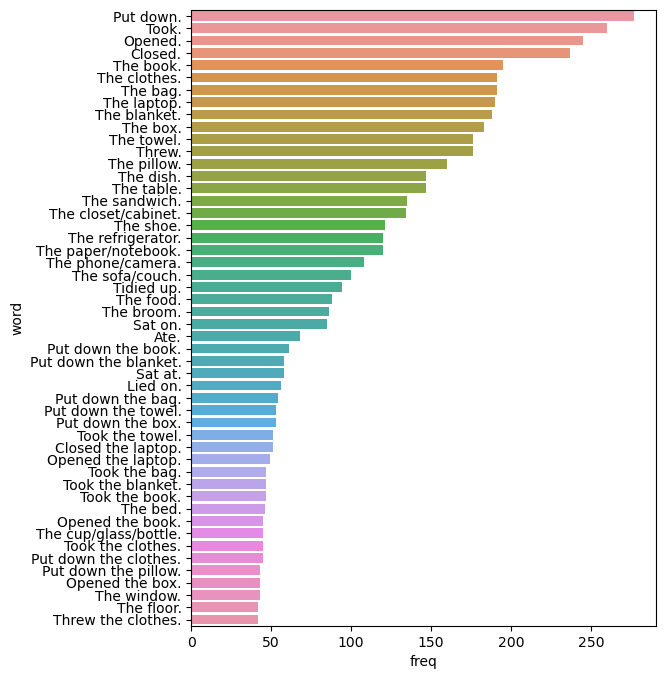

In [93]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [94]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6758, 5)

In [95]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [96]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 68.20%


In [97]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [98]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2219        63.86%  
Sequence            3430        74.66%  
Prediction           623        80.42%  
Feasibility          486        74.49%  


In [99]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        92.54%  
Sequence            3586        95.65%  
Prediction           624        99.84%  
Feasibility          490        99.18%  
Overall             7098        95.21%  
